In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split



In [46]:
data=[]
with open("E:\EdgeAi\WISDM_ar_latest\WISDM_ar_v1.1\WISDM_ar_v1.1_raw.txt",'r')as file:
    for line in file:
        parts=line.strip().split(',')
        if len(parts)==6:
            try:
                user=int(parts[0])
                activity=parts[1]
                timestamp=int(parts[2])
                x=float(parts[3])
                y=float(parts[4])
                z_str = parts[5].replace(';', '')    
                z = float(z_str)
                data.append([user, activity, timestamp, x, y, z])
            except:
                continue      

df=pd.DataFrame(data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

df.to_csv('wisdm_cleaned.csv', index=False)
df.head(800)

    
      
 

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
795,33,Walking,49415992264000,-0.612916,3.568531,-1.797886
796,33,Walking,49416042129000,-0.803601,8.689782,-0.694638
797,33,Walking,49416152298000,1.688923,11.264028,-0.422231
798,33,Walking,49416252273000,1.225831,15.050485,-0.272407


Unique Activities: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']
Dataset Shape: (1086465, 6)


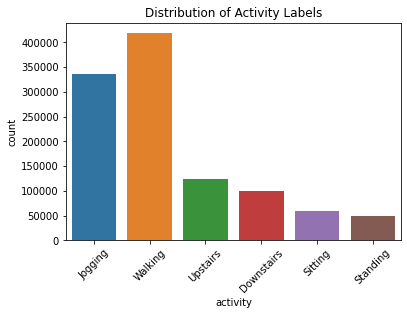

In [47]:

print("Unique Activities:", df['activity'].unique())
print("Dataset Shape:", df.shape)

sns.countplot(data=df, x='activity')
plt.xticks(rotation=45)
plt.title("Distribution of Activity Labels")
plt.show()


In [48]:
#add Magnitude feature
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [49]:
df

,user,activity,timestamp,x,y,z,magnitude
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804
...,...,...,...,...,...,...,...
1086460,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,9.290910
1086461,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,9.319125
1086462,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,9.338463
1086463,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,9.280329


In [50]:
#Convert activity to activity_code(string to int)
le = LabelEncoder()


le = LabelEncoder()
df['activity_code'] = le.fit_transform(df['activity'])

activity_labels = dict(enumerate(le.classes_))

print("Activity Labels:", activity_labels)


Activity Labels: {0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}


In [51]:

window_size = 60 
step_size = 20

segments = []
labels = []

for start in range(0, len(df) - window_size, step_size):
    end = start + window_size
    segment = df.iloc[start:end]
    if len(segment['activity_code'].unique()) == 1:
        x = segment['x'].values
        y = segment['y'].values
        z = segment['z'].values
        magnitude = segment['magnitude'].values

        segments.append([x, y, z, magnitude])
        labels.append(segment['activity_code'].iloc[0])

segments = np.asarray(segments)
labels = np.asarray(labels)

X = np.transpose(segments, (0, 2, 1))  # (num_samples, 60, 4)
y = labels
print(f"Segments shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Segments shape: (53188, 60, 4)
Labels shape: (53188,)


In [52]:
scaler = StandardScaler()
num_samples, timesteps, num_features = X.shape

X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, timesteps, num_features)


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:
num_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [56]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten و Dense
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


C:\Users\sheydameh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [58]:
history = model.fit(X_train, y_train_cat,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test_cat))


Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7210 - loss: 0.7795 - val_accuracy: 0.8570 - val_loss: 0.3542
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8453 - loss: 0.4124 - val_accuracy: 0.8954 - val_loss: 0.2752
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8687 - loss: 0.3527 - val_accuracy: 0.9102 - val_loss: 0.2371
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8840 - loss: 0.3130 - val_accuracy: 0.9303 - val_loss: 0.2055
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8962 - loss: 0.2825 - val_accuracy: 0.9369 - val_loss: 0.1822
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9045 - loss: 0.2608 - val_accuracy: 0.9445 - val_loss: 0.1705
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9105 - loss: 0.2503 - val_accuracy: 0.9429 - val_loss: 0.1626
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9151 - loss: 0.2324 - val_ac

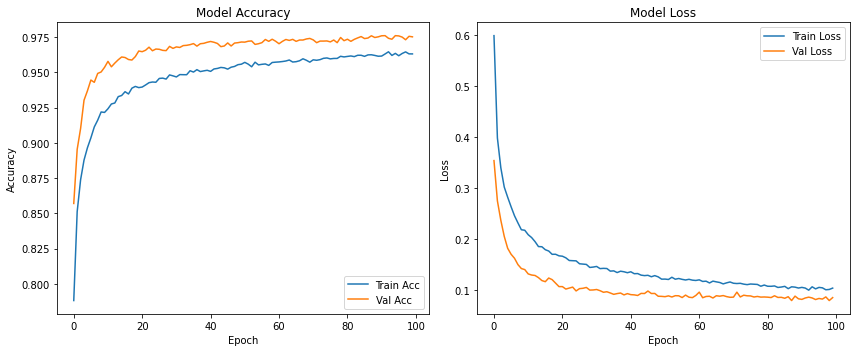

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
y_predic= model.predict(X_test)

print(y_predic.shape)


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10638, 6)


In [62]:
print(y_test_cat.shape)

(10638, 6)


In [68]:


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_cat, y_predic)
print(mse)


0.0066677948366096924


In [70]:
mse = model.evaluate(X_test, y_test_cat)


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9742 - loss: 0.0916


In [32]:
y_predic = np.array(y_predic)
print(y_predic)

[[5.66343172e-03 5.85706555e-04 1.62204706e-20 0.00000000e+00
  9.75006402e-01 1.87444482e-02]
 [2.51051175e-30 0.00000000e+00 1.00000000e+00 0.00000000e+00
  9.22783612e-24 3.16225918e-31]
 [6.70399901e-19 1.68373804e-09 3.80313917e-38 0.00000000e+00
  2.08413661e-10 1.00000000e+00]
 ...
 [9.13072610e-04 1.14525879e-04 6.81265529e-16 1.72882963e-30
  4.55396846e-02 9.53432739e-01]
 [9.00544546e-05 1.02713315e-07 5.15001826e-03 9.92675841e-01
  2.06339569e-03 2.05816414e-05]
 [4.76668938e-04 2.17065789e-07 1.24162210e-24 0.00000000e+00
  1.21857738e-04 9.99401212e-01]]


In [72]:
import numpy as np

y_pred_labels = np.argmax(y_predic, axis=1)
print(y_pred_labels)

[4 2 5 ... 5 3 5]


In [75]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("activity_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmphcrmn_jn\assets


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmphcrmn_jn\assets


Saved artifact at 'C:\Users\SHEYDA~1\AppData\Local\Temp\tmphcrmn_jn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 4), dtype=tf.float32, name='keras_tensor_58')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2407281637856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407281637504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407311758080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407341792768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407278615888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407453467392: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [83]:
interpreter = tf.lite.Interpreter(model_path="activity_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sample_input = X_test[1:2].astype(np.float32) 

interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

print("Predicted probabilities:", output)
print("Predicted class:", np.argmax(output))


Predicted probabilities: [[3.4675428e-30 0.0000000e+00 1.0000000e+00 0.0000000e+00 3.1364559e-22
  8.2773904e-33]]
Predicted class: 2


In [84]:
y_test_cat[1:2]

array([[0., 0., 1., 0., 0., 0.]])